For now we are grouping graphs according to power. It may also make sense to group graphs according to their clustering.

Parameters to adjust:
- log-increase (alpha such that at 365 more than 0.99 infectiousness) versus lin-increase (cutoff=365)
- immunity length (90 days)
- the power law distribution (group graphs accordingly)
- the clustering (group graphs accordingly)

Measuring the sensitivity of the parameters:
- proportion of infecteds at time = 730
- maximum number of infections over 730 days
- number of times that more than 1% of the population is infected

In [1]:
# Load the required packages
import glob
from igraph import *
import pickle
import random as rd
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import math
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns

In [2]:
# # Recalculate the mean_edge probability after excluding all graphs with more than 2x10^6 edges 
# average_degrees = []
# for pw in (2.4,2.6,2.8,3.0,3.2):
#     for tr in (0.05,0.1,0.15,0.2):
#         file_names = glob.glob('../Graphs/Graphs_{}_{}/*.pkl'.format(pw,tr))
#         for g_name in file_names:
#             g = pickle.load(open(g_name,"rb"))
#             if g.ecount() <= 2*(10**6):
#                 average_degrees.append(np.mean(g.degree()))
# print(np.mean(average_degrees))

In [3]:
# Setting the probability of infection such that each node infects on average one other node (r=1)
mean_edge = 217.8505397260274 #480.55348360000005
probs_inf = {1: 0.001, 2: 0.01, 3: 0.02, 4: 0.018, 5: 0.012,
             6: 0.008, 7: 0.005, 8: 0.002, 9: 0.0015, 10: 0.001,
             11: 0.001, 12: 0.001, 13: 0.001, 14: 0.001}
# As per the prob. density function calculated by: https://pubmed.ncbi.nlm.nih.gov/32145466/ (Fig. 1)
total_prob = np.sum(list(probs_inf.values()))
adjust_prob = total_prob*mean_edge

In [4]:
# Transmission rate is dependent on the time of last infection
def log_increase(day,alpha=1/10):
    val = alpha*math.log(1.0+day)/(1.0+(alpha*math.log(1.0+day)))
    return(val)
def lin_increase(day,cutoff=365):
    if day <= cutoff:
        val = day/cutoff
    else:
        val = 1
    return(val)

In [5]:
# SIRS Model Simulation
def run_SIRS(g,days=730,infection_len=14,immunity_len=90,alpha=1,cutoff=365,logincrease=False):
    # days = No of days for which to run the model, 1095 days in 3 years
    # infection_len = No of days that an infected individual can transmit the virus
    # immunity_len = No of days that an individual stays immune after infection
    pop = len(g.vs()) # population size
    # Set the default state as susceptible
    for node in range(len(g.vs)):
        g.vs[node]["state"] = "S" # Possible states are S & I & R
        g.vs[node]["duration"] = 0 # No of consecutive days in state I
        g.vs[node]["last"] = None # Time since last infection
        g.vs[node]["infections"] = 0 # Number of infections
    # Set a random node in the network as infected (patient zero)
    i = rd.randint(0, pop-1)
    g.vs[i]["state"] = "I"
    g.vs[node]["last"] = None
    # Keep track of the number of susceptible and the number of infecteds in the population
    nb_S = [pop/pop]
    nb_I = [1/pop]
    nb_R = [0/pop]
    # SIRS Simulation
    for time in range(days):
        # For all Recovered nodes update time of last infection and if no longer immune reset to Susceptible
        for n in g.vs.select(state_eq = "R"):
            g.vs[n.index]["last"] += 1
            if g.vs[n.index]["last"] > immunity_len:
                g.vs[n.index]["state"] = "S"
                g.vs[n.index]["last"] = 0 # reset time of last recovery
        # For all susceptible nodes update time of last infection
        for n in g.vs.select(state_eq = "S"):
            if g.vs[n.index]["last"] is not None:
                g.vs[n.index]["last"] += 1
        # For all infected nodes simulate transmission
        for n in g.vs.select(state_eq = "I"):
            g.vs[n.index]["duration"] += 1
            day_inf = g.vs[n.index]["duration"]
            if day_inf >= infection_len:
                g.vs[n.index]["state"] = "R" # need to make this person immune for a given time period
                g.vs[n.index]["duration"] = 0 # reset the infection duration to zero
                g.vs[n.index]["last"] = 0 # reset time of last infection
            else:
                if g.vs[n.index]["last"] == None:
                    damping_factor = 1
                else:
                    if logincrease:
                        damping_factor = log_increase(g.vs[n.index]["last"],alpha=alpha) #log_increase(g.vs[n.index]["last"])
                    else:
                        damping_factor = lin_increase(g.vs[n.index]["last"],cutoff=cutoff) #log_increase(g.vs[n.index]["last"])
                for nb in g.neighbors(n): # iterate through neighbours of infected node
                        if g.vs[nb]["state"] == "S":
                                r = rd.random()
                                if r < probs_inf[day_inf]*damping_factor/adjust_prob: #do not get second peaks if the probability of infeaction is too high
                                    # Infection Occurs
                                    g.vs[nb]["state"] = "I"
                                    g.vs[nb]["duration"] = 0 # reset the infection duration to zero
                                    g.vs[nb]["infections"] += 1 # update the number of times that node got infected
        nb_S.append(len(g.vs.select(state_eq = "S"))/pop) #no. of susceptibles in population
        nb_I.append(len(g.vs.select(state_eq = "I"))/pop) #no. of infecteds in population
        nb_R.append(len(g.vs.select(state_eq = "R"))/pop) #no. of immunes in population
    max_inf = np.max(g.vs["infections"])
    return (nb_S, nb_I, nb_R, max_inf)

In [6]:
# Parameters to adjust (do all possible combinations of *0.7 and *1.3)
loginc = False
imlen = 90*0.7 # immunity length
adj = 1*1.3 # adjust the probability of infection
alph = 16.8 # damping factor; applied when logincrease = True
# Vary cut only if loginc is False
cut = 365*1.3 # cutoff; applied when logincrease = False

# Parameters of Interest
adjust_prob = adjust_prob*adj
prop_inf = [] # proportion of infected after 2 years 
max_infs = [] # maximum percentage of infecteds at a time
no_peaks = [] # percentage of days that more than 1% of the pop'n is infected
max_reinf = [] # maximum number of reinfections that a node had

# Get file names of the generated networks
pw = ['2.4', '2.6', '2.8', '3.0', '3.2'] # set of graphs with that power
tr = ['0.05', '0.1', '0.15', '0.2'] # set of graphs with that transitivity
output = pd.DataFrame(columns=['Nodes', 'Edges', 'Power', 'Transitivity', 'AdjPob', 'max_infs', 'prop_inf', 'max_reinf', 'no_peaks'])
for _pw in pw:
    for _tr in tr:
        file_names = glob.glob('../Graphs/Graphs_{}_{}/*.pkl'.format(_pw, _tr))
        # Interate through the networks and run SIRS model
        for g_name in file_names:
            g = pickle.load(open(g_name,"rb"))
            if g.ecount() <= 2*(10**6):
                pop = float(g.vcount()) # population size 
                al = 0.3 # line transparancy
                time = 730
                power = power_law_fit(g.degree()).alpha
                trans = g.transitivity_undirected()
                # Run multiple simulation for each network
                for i in range(10):
                    no_S,no_I,no_R,max_rI = run_SIRS(g,days=time,infection_len=14,immunity_len=imlen,alpha=alph,cutoff=cut,logincrease=loginc)
                    # Save the parameters of interest
                    output = output.append({'Nodes':g.vcount(), 'Edges':g.ecount(), 'Power':power, 'Transitivity':trans, 'AdjPob': adj, 'max_infs':max(no_I)*pop, 'prop_inf':no_I[-1]*pop, 'max_reinf':max_rI, 'no_peaks':np.sum([i>0.01 for i in no_I])}, ignore_index=True)

In [7]:
if loginc:
    output.to_csv("../Results/output_loginc_alph{}_imlen{}_adj{}.csv".format(alph,imlen,adj))
else:
    output.to_csv("../Results/output_lininc_cut{}_imlen{}_adj{}.csv".format(cut,imlen,adj))

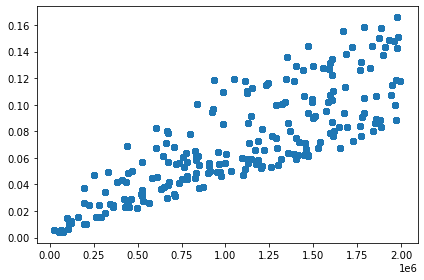

In [8]:
fig, ax = plt.subplots()
ax.scatter(output['Edges'], output['Transitivity'])
fig.tight_layout()
plt.show()